In [1]:
import os
import sys
# os.chdir('../')
sys.path.append(os.getcwd())

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.decomposition import PCA
from scipy.stats import fisher_exact, chi2_contingency
from sklearn.manifold import TSNE, MDS
from tqdm import tqdm
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, precision_score, recall_score, roc_curve
from multipy.fwer import sidak, hochberg
import random

from utils.viz_utils import plot_usage_matrix_pca, plot_boxplots_for_usage_matrix, _plot_feature_importance, plot_v_usage_hist, \
                                plot_cluster_map, significant_clones_distribution, plot_results_for_hla_class, plot_generated_to_real_distribution, \
                            plot_olga_cleanup_data, plot_clusters_of_clonotypes, plot_cooccurence_heatmap_with_epitopes_labeling, plot_waterfall_by_column, \
                            plot_feature_importances
from utils.ml_utils import get_parameters, prepare_data, evaluate_models, split_data_by_batch, split_data, cross_validation_between_batches, make_hla_predictor
from utils.data_utils import prepare_run_column
from utils.stats_utils import evaluate_anova_testing, evaluate_mannwhitneyu_testing
from utils.clustering_utils import seqs2hamming
from utils.weblogo_utils import create_web_logo
from source.alpha_beta_paired_clones_search import make_metaclone_cm

import warnings
warnings.filterwarnings('ignore')


import importlib
imported_module = importlib.import_module("utils.viz_utils")
importlib.reload(imported_module)

/home/evlasova/tcr-covid-classifier


<module 'utils.viz_utils' from '/home/evlasova/tcr-covid-classifier/utils/viz_utils.py'>

In [2]:
vdjdb = pd.read_csv('data/vdjdb.txt', sep='\t')

# Training separate α/β classifiers

In [3]:
data_beta = prepare_data(run_to_number_of_clones_path='data/run_to_number_of_clones_fmba_TRB.csv',
                     desc_path='data/standardized_usage_matrix_fmba_TRA.csv',
                     clonotype_matrix_path='data/significant_clone_matrix_fisher_fmba_TRB_vdjdb.csv',
                     hla_keys_path='data/hla_keys.csv',
                     make_freq=True, 
                     use_hla_clones=False, 
                     use_hla_bool=True, 
                     use_standardization=True,
                     raw_target_column='covid',
                     raw_target_clumn_success_label='covid',)
X_train, y_train, X_test, y_test = split_data(data=data_beta, y_column='covid', by='is_test_run')
best_clfs_beta = evaluate_models(X_train, y_train, X_test, y_test, get_parameters(), scoring_function='f1_weighted', debug=True)

Started evaluating svm
Best params for svm: {'model__C': 5, 'model__kernel': 'rbf', 'model__probability': True, 'model__random_state': 42}
Test f1-score for the best model 0.66

Started evaluating ab
Best params for ab: {'model__base_estimator': DecisionTreeClassifier(max_depth=1), 'model__n_estimators': 200, 'model__random_state': 42}
Test f1-score for the best model 0.55

Started evaluating knn
Best params for knn: {'model__leaf_size': 1, 'model__n_neighbors': 50, 'model__weights': 'distance'}
Test f1-score for the best model 0.60

Started evaluating rfc
Best params for rfc: {'model__max_depth': 1, 'model__min_samples_leaf': 8, 'model__n_estimators': 50, 'model__n_jobs': -1, 'model__oob_score': False, 'model__random_state': 42}
Test f1-score for the best model 0.63

Started evaluating mlpclassifier
Best params for mlpclassifier: {'model__alpha': 0.001, 'model__hidden_layer_sizes': (100, 50, 25, 10), 'model__learning_rate': 'constant', 'model__max_iter': 1000, 'model__random_state': 4

In [4]:
beta_cm = pd.read_csv('data/significant_clone_matrix_fisher_fmba_TRB_vdjdb.csv').drop(columns=['Unnamed: 0'])

In [5]:
beta_vdjdb_clones = pd.read_csv('data/significant_clone_matrix_fisher_fmba_TRB_vdjdb.csv').drop(columns=['Unnamed: 0', 'run']).columns

In [6]:
beta_covid_vdjdb = vdjdb[(vdjdb['antigen.species'] == 'SARS-CoV-2') & (vdjdb.gene == 'TRB')]\
                        [['cdr3', 'antigen.epitope']].rename(columns={'antigen.epitope': 'cluster'})
beta_covid_vdjdb

,cdr3,cluster
419,CASSQTTKDEQYF,KTFPPTEPK
420,CASSQGQKDEQYF,KTFPPTEPK
421,CASSQFTGRKEKLFF,KTFPPTEPK
422,CASSLTSGGPTSDTQYF,LLYDANYFL
423,CASTTPVTERYNEQFF,LLYDANYFL
...,...,...
89069,CASSALVAFSTDTQYF,QYIKWPWYI
89071,CASSSLAGEVNEQFF,QYIKWPWYI
89073,CASSSYTQRGLDYTGELFF,QYIKWPWYI
89074,CSVEDPMGVGTEAFF,QYIKWPWYI


In [7]:
metaclone_beta_cm = make_metaclone_cm(beta_cm, beta_covid_vdjdb)

In [8]:
metaclone_beta_cm.to_csv('data/clone_matrix_covid_fmba_TRB_metaclone_vdjdb.csv')

In [9]:
data_alpha = prepare_data(run_to_number_of_clones_path='data/run_to_number_of_clones_fmba_TRA.csv',
                     desc_path='data/standardized_usage_matrix_fmba_TRA.csv',
                     clonotype_matrix_path='data/significant_clone_matrix_fisher_fmba_TRA_vdjdb.csv',
                     hla_keys_path='data/hla_keys.csv',
                     make_freq=True,
                     use_hla_clones=False,
                     use_hla_bool=True,
                     use_standardization=True,
                     raw_target_column='covid',
                     raw_target_clumn_success_label='covid',)
X_train_alpha, y_train_alpha, X_test_alpha, y_test_alpha = split_data(data=data_alpha, y_column='covid', by='is_test_run')

best_clfs_alpha = evaluate_models(X_train_alpha, y_train_alpha, 
                                  X_test_alpha, y_test_alpha, 
                                  get_parameters(), scoring_function='f1_weighted', debug=True)

Started evaluating svm
Best params for svm: {'model__C': 5, 'model__kernel': 'rbf', 'model__probability': True, 'model__random_state': 42}
Test f1-score for the best model 0.63

Started evaluating ab
Best params for ab: {'model__base_estimator': DecisionTreeClassifier(max_depth=1), 'model__n_estimators': 100, 'model__random_state': 42}
Test f1-score for the best model 0.65

Started evaluating knn
Best params for knn: {'model__leaf_size': 1, 'model__n_neighbors': 10, 'model__weights': 'uniform'}
Test f1-score for the best model 0.59

Started evaluating rfc
Best params for rfc: {'model__max_depth': 1, 'model__min_samples_leaf': 8, 'model__n_estimators': 50, 'model__n_jobs': -1, 'model__oob_score': False, 'model__random_state': 42}
Test f1-score for the best model 0.63

Started evaluating mlpclassifier
Best params for mlpclassifier: {'model__alpha': 0.01, 'model__hidden_layer_sizes': (100, 60, 30, 10), 'model__learning_rate': 'constant', 'model__max_iter': 1000, 'model__random_state': 42}

In [10]:
alpha_cm = pd.read_csv('data/significant_clone_matrix_fisher_fmba_TRA_vdjdb.csv').drop(columns=['Unnamed: 0'])
alpha_vdjdb_clones = pd.read_csv('data/significant_clone_matrix_fisher_fmba_TRA_vdjdb.csv').drop(columns=['Unnamed: 0', 'run']).columns
alpha_covid_vdjdb = vdjdb[(vdjdb['antigen.species'] == 'SARS-CoV-2') & (vdjdb.gene == 'TRA')]\
                        [['cdr3', 'antigen.epitope']].rename(columns={'antigen.epitope': 'cluster'})
metaclone_alpha_cm = make_metaclone_cm(alpha_cm, alpha_covid_vdjdb)
metaclone_alpha_cm.to_csv('data/clone_matrix_covid_fmba_TRA_metaclone_vdjdb.csv')

# Training joint αβ classifier

In [11]:
data_alpha_for_joint = prepare_data(run_to_number_of_clones_path='data/run_to_number_of_clones_fmba_TRA.csv',
                     desc_path='data/standardized_usage_matrix_fmba_TRA.csv',
                     clonotype_matrix_path='data/significant_clone_matrix_fisher_fmba_TRA_vdjdb.csv',
                     hla_keys_path='data/hla_keys.csv',
                     make_freq=True,
                     use_hla_clones=False,
                     use_hla_bool=False,
                     use_standardization=True,
                     raw_target_column='covid',
                     raw_target_clumn_success_label='covid',
                     metadata_columns=['project', 'is_test_run'])
print('alpha ready')
data_beta_for_joint = prepare_data(run_to_number_of_clones_path='data/run_to_number_of_clones_fmba_TRB.csv',
                     desc_path='data/standardized_usage_matrix_fmba_TRA.csv',
                     clonotype_matrix_path='data/significant_clone_matrix_fisher_fmba_TRB_vdjdb.csv',
                     hla_keys_path='data/hla_keys.csv',
                     make_freq=True, 
                     use_hla_clones=False, 
                     use_hla_bool=True, 
                     use_standardization=True,
                     raw_target_column='covid',
                     raw_target_clumn_success_label='covid',)
data_joint = pd.concat([data_beta_for_joint[[x for x in data_beta_for_joint.columns if x.startswith('CAS')]], data_alpha_for_joint], axis=1)


alpha ready


In [12]:
data_joint

,CASSQTTKDEQYF,CASSQGQKDEQYF,CASSQFTGRKEKLFF,CASSLTSGGPTSDTQYF,CASTTPVTERYNEQFF,CASTTSRGAISTDTQYF,CASSQGTGGANEQYF,CASSLAGSTEAFF,CASSLAGSTEAFF.1,CASSLTSGGPVTDTQYF,...,CAFMKINQFYF,CAFLNAGGTSYGKLTF,CAVYNQGGKLIF,CAVRALYNFNKFYF,CAVESYNTDKLIF,CLVGENSGGFKTIF,CAMREGQGNAGNMLTF,covid,project,is_test_run
0,-0.062793,-0.11064,-0.04418,-0.032359,0.0,0.0,-0.110069,0.745466,0.745466,-0.07678,...,-0.161577,1.677709,0.046260,-0.371942,-1.305344,-0.222082,-0.400412,1,2020/10_FMBA_NovaSeq5,False
1,-0.062793,-0.11064,-0.04418,-0.032359,0.0,0.0,-0.110069,-1.080899,-1.080899,-0.07678,...,-0.161577,0.490398,-1.290622,-0.371942,1.036795,2.029925,-0.400412,1,2020/10_FMBA_NovaSeq5,False
2,-0.062793,-0.11064,-0.04418,-0.032359,0.0,0.0,-0.110069,-0.535745,-0.535745,-0.07678,...,-0.161577,0.256703,-1.412024,-0.371942,-0.076025,-0.222082,-0.400412,0,2020/10_FMBA_NovaSeq5,False
3,-0.062793,-0.11064,-0.04418,-0.032359,0.0,0.0,-0.110069,-1.080899,-1.080899,-0.07678,...,-0.161577,-1.375933,0.721560,-0.371942,0.148967,-0.222082,3.757343,1,2020/10_FMBA_NovaSeq5,False
4,-0.062793,-0.11064,-0.04418,-0.032359,0.0,0.0,-0.110069,2.058364,2.058364,-0.07678,...,-0.161577,-1.375933,0.018445,-0.371942,-0.168249,-0.222082,-0.400412,1,2020/10_FMBA_NovaSeq5,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,-0.062793,-0.11064,-0.04418,-0.032359,0.0,0.0,-0.110069,-1.080899,-1.080899,-0.07678,...,-0.161577,3.413831,-2.501948,-0.371942,4.104447,-0.222082,-0.400412,0,2020/10_FMBA_NovaSeq4,False
952,-0.062793,-0.11064,-0.04418,-0.032359,0.0,0.0,-0.110069,-0.180133,-0.180133,-0.07678,...,-0.161577,0.514424,-1.450302,-0.371942,2.964779,-0.222082,-0.400412,0,2020/10_FMBA_NovaSeq4,False
953,-0.062793,-0.11064,-0.04418,-0.032359,0.0,0.0,-0.110069,-1.080899,-1.080899,-0.07678,...,-0.161577,1.029539,-1.163733,-0.371942,0.505894,-0.222082,-0.400412,0,2020/10_FMBA_NovaSeq4,False
954,-0.062793,-0.11064,-0.04418,-0.032359,0.0,0.0,-0.110069,-1.080899,-1.080899,-0.07678,...,-0.161577,-1.375933,-0.078940,-0.371942,0.880974,-0.222082,-0.400412,0,2020/10_FMBA_NovaSeq4,False


In [13]:
X_train_joint, y_train_joint, X_test_joint, y_test_joint = split_data(data=data_joint.drop(columns=['project']), y_column='covid', by='is_test_run')

best_clfs_joint = evaluate_models(X_train_joint, y_train_joint, X_test_joint, y_test_joint, 
                                  get_parameters(), scoring_function='f1_weighted', debug=True)

Started evaluating svm
Best params for svm: {'model__C': 1, 'model__kernel': 'linear', 'model__probability': True, 'model__random_state': 42}
Test f1-score for the best model 0.61

Started evaluating ab
Best params for ab: {'model__base_estimator': DecisionTreeClassifier(max_depth=1), 'model__n_estimators': 200, 'model__random_state': 42}
Test f1-score for the best model 0.63

Started evaluating knn
Best params for knn: {'model__leaf_size': 1, 'model__n_neighbors': 10, 'model__weights': 'distance'}
Test f1-score for the best model 0.58

Started evaluating rfc
Best params for rfc: {'model__max_depth': 1, 'model__min_samples_leaf': 8, 'model__n_estimators': 50, 'model__n_jobs': -1, 'model__oob_score': False, 'model__random_state': 42}
Test f1-score for the best model 0.63

Started evaluating mlpclassifier
Best params for mlpclassifier: {'model__alpha': 1e-05, 'model__hidden_layer_sizes': (150, 100, 50, 25, 10), 'model__learning_rate': 'constant', 'model__max_iter': 1000, 'model__random_s

# Training classifiers based on metaclones

In [14]:
data_beta_meta = prepare_data(run_to_number_of_clones_path='data/run_to_number_of_clones_fmba_TRB.csv',
                     desc_path='data/standardized_usage_matrix_fmba_TRA.csv',
                     clonotype_matrix_path='data/clone_matrix_covid_fmba_TRB_metaclone_vdjdb.csv',
                     hla_keys_path='data/hla_keys.csv',
                     make_freq=True,
                     use_hla_clones=False,
                     use_hla_bool=True,
                     use_standardization=True,
                     raw_target_column='covid',
                     raw_target_clumn_success_label='covid',
                     metadata_columns=['is_test_run', 'project'])

data_alpha_meta = prepare_data(run_to_number_of_clones_path='data/run_to_number_of_clones_fmba_TRA.csv',
                     desc_path='data/standardized_usage_matrix_fmba_TRA.csv',
                     clonotype_matrix_path='data/clone_matrix_covid_fmba_TRA_metaclone_vdjdb.csv',
                     hla_keys_path='data/hla_keys.csv',
                     make_freq=True,
                     use_hla_clones=False,
                     use_hla_bool=True,
                     use_standardization=True,
                     raw_target_column='covid',
                     raw_target_clumn_success_label='covid',
                     metadata_columns=['is_test_run', 'project'])

data_beta_meta = data_beta_meta.rename(columns={f'cluster_{x}': f'b_cluster_{x}' for x in range(len(data_beta_meta.columns))})
data_alpha_meta = data_alpha_meta.rename(columns={f'cluster_{x}': f'a_cluster_{x}' for x in range(len(data_beta_meta.columns))})
data_joint_meta = pd.concat([data_beta_meta[[x for x in data_beta_meta.columns if x.startswith('b')]], data_alpha_meta], axis=1)

In [15]:
X_train_beta_m, y_train_beta_m, X_test_beta_m, y_test_beta_m = split_data(data=data_beta_meta.drop(columns=['project']), 
                                                       y_column='covid') 
X_train_alpha_m, y_train_alpha_m, X_test_alpha_m, y_test_alpha_m = split_data(data=data_alpha_meta.drop(columns=['project']), 
                                                       y_column='covid') 
X_train_joint_m, y_train_joint_m, X_test_joint_m, y_test_joint_m = split_data(data=data_joint_meta.drop(columns=['project']), 
                                                       y_column='covid')

In [16]:
best_clfs_beta_m = evaluate_models(X_train_beta_m, y_train_beta_m, X_test_beta_m, y_test_beta_m, 
                                  get_parameters(), scoring_function='f1_weighted', debug=True)

best_clfs_alpha_m = evaluate_models(X_train_alpha_m, y_train_alpha_m, X_test_alpha_m, y_test_alpha_m, 
                                  get_parameters(), scoring_function='f1_weighted', debug=True)

best_clfs_joint_m = evaluate_models(X_train_joint_m, y_train_joint_m, X_test_joint_m, y_test_joint_m, 
                                  get_parameters(), scoring_function='f1_weighted', debug=True)

Started evaluating svm
Best params for svm: {'model__C': 5, 'model__kernel': 'rbf', 'model__probability': True, 'model__random_state': 42}
Test f1-score for the best model 0.65

Started evaluating ab
Best params for ab: {'model__base_estimator': DecisionTreeClassifier(max_depth=1), 'model__n_estimators': 125, 'model__random_state': 42}
Test f1-score for the best model 0.58

Started evaluating knn
Best params for knn: {'model__leaf_size': 1, 'model__n_neighbors': 5, 'model__weights': 'uniform'}
Test f1-score for the best model 0.62

Started evaluating rfc
Best params for rfc: {'model__max_depth': 1, 'model__min_samples_leaf': 8, 'model__n_estimators': 50, 'model__n_jobs': -1, 'model__oob_score': False, 'model__random_state': 42}
Test f1-score for the best model 0.63

Started evaluating mlpclassifier
Best params for mlpclassifier: {'model__alpha': 0.01, 'model__hidden_layer_sizes': (150, 100, 50, 25, 10), 'model__learning_rate': 'constant', 'model__max_iter': 1000, 'model__random_state':

In [17]:
all_clfs = {
     'beta': best_clfs_beta,
     'alpha': best_clfs_alpha,
     'joint': best_clfs_joint,
     'beta_meta': best_clfs_beta_m,
     'alpha_meta': best_clfs_alpha_m,
     'joint_meta': best_clfs_joint_m,
}
X_test_data={
     'beta': X_test,
     'alpha': X_test_alpha,
     'joint': X_test_joint,
     'beta_meta': X_test_beta_m,
     'alpha_meta': X_test_alpha_m,
     'joint_meta': X_test_joint_m,
}
y_test_data={
     'beta': y_test,
     'alpha': y_test_alpha,
     'joint': y_test_joint,
     'beta_meta': y_test_beta_m,
     'alpha_meta': y_test_alpha_m,
     'joint_meta': y_test_joint_m,
}
X_train_data={
     'beta': X_train,
     'alpha': X_train_alpha,
     'joint': X_train_joint,
     'beta_meta': X_train_beta_m,
     'alpha_meta': X_train_alpha_m,
     'joint_meta': X_train_joint_m,
}
y_train_data={
     'beta': y_train,
     'alpha': y_train_alpha,
     'joint': y_train_joint,
     'beta_meta': y_train_beta_m,
     'alpha_meta': y_train_alpha_m,
     'joint_meta': y_train_joint_m,
}

In [18]:
data_joint

,CASSQTTKDEQYF,CASSQGQKDEQYF,CASSQFTGRKEKLFF,CASSLTSGGPTSDTQYF,CASTTPVTERYNEQFF,CASTTSRGAISTDTQYF,CASSQGTGGANEQYF,CASSLAGSTEAFF,CASSLAGSTEAFF.1,CASSLTSGGPVTDTQYF,...,CAFMKINQFYF,CAFLNAGGTSYGKLTF,CAVYNQGGKLIF,CAVRALYNFNKFYF,CAVESYNTDKLIF,CLVGENSGGFKTIF,CAMREGQGNAGNMLTF,covid,project,is_test_run
0,-0.062793,-0.11064,-0.04418,-0.032359,0.0,0.0,-0.110069,0.745466,0.745466,-0.07678,...,-0.161577,1.677709,0.046260,-0.371942,-1.305344,-0.222082,-0.400412,1,2020/10_FMBA_NovaSeq5,False
1,-0.062793,-0.11064,-0.04418,-0.032359,0.0,0.0,-0.110069,-1.080899,-1.080899,-0.07678,...,-0.161577,0.490398,-1.290622,-0.371942,1.036795,2.029925,-0.400412,1,2020/10_FMBA_NovaSeq5,False
2,-0.062793,-0.11064,-0.04418,-0.032359,0.0,0.0,-0.110069,-0.535745,-0.535745,-0.07678,...,-0.161577,0.256703,-1.412024,-0.371942,-0.076025,-0.222082,-0.400412,0,2020/10_FMBA_NovaSeq5,False
3,-0.062793,-0.11064,-0.04418,-0.032359,0.0,0.0,-0.110069,-1.080899,-1.080899,-0.07678,...,-0.161577,-1.375933,0.721560,-0.371942,0.148967,-0.222082,3.757343,1,2020/10_FMBA_NovaSeq5,False
4,-0.062793,-0.11064,-0.04418,-0.032359,0.0,0.0,-0.110069,2.058364,2.058364,-0.07678,...,-0.161577,-1.375933,0.018445,-0.371942,-0.168249,-0.222082,-0.400412,1,2020/10_FMBA_NovaSeq5,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,-0.062793,-0.11064,-0.04418,-0.032359,0.0,0.0,-0.110069,-1.080899,-1.080899,-0.07678,...,-0.161577,3.413831,-2.501948,-0.371942,4.104447,-0.222082,-0.400412,0,2020/10_FMBA_NovaSeq4,False
952,-0.062793,-0.11064,-0.04418,-0.032359,0.0,0.0,-0.110069,-0.180133,-0.180133,-0.07678,...,-0.161577,0.514424,-1.450302,-0.371942,2.964779,-0.222082,-0.400412,0,2020/10_FMBA_NovaSeq4,False
953,-0.062793,-0.11064,-0.04418,-0.032359,0.0,0.0,-0.110069,-1.080899,-1.080899,-0.07678,...,-0.161577,1.029539,-1.163733,-0.371942,0.505894,-0.222082,-0.400412,0,2020/10_FMBA_NovaSeq4,False
954,-0.062793,-0.11064,-0.04418,-0.032359,0.0,0.0,-0.110069,-1.080899,-1.080899,-0.07678,...,-0.161577,-1.375933,-0.078940,-0.371942,0.880974,-0.222082,-0.400412,0,2020/10_FMBA_NovaSeq4,False


In [19]:
model_df = []
f1_df = []
data_type_df = []
for data_type in ['beta','alpha','joint','beta_meta','alpha_meta','joint_meta']:
    for model in ['svm', 'ab', 'knn', 'rfc', 'mlpclassifier', 'xgboost']:
        cur_score = f1_score(y_test_data[data_type], all_clfs[data_type][0][model].predict(X_test_data[data_type]))
        model_df.append(model)
        data_type_df.append(data_type)
        f1_df.append(cur_score)
comparison_df = pd.DataFrame({'model':model_df, 'f1': f1_df, 'data_type':data_type_df})

In [20]:
comparison_df

,model,f1,data_type
0,svm,0.658065,beta
1,ab,0.550725,beta
2,knn,0.597561,beta
3,rfc,0.627219,beta
4,mlpclassifier,0.647059,beta
5,xgboost,0.615385,beta
6,svm,0.631579,alpha
7,ab,0.647059,alpha
8,knn,0.588235,alpha
9,rfc,0.627219,alpha


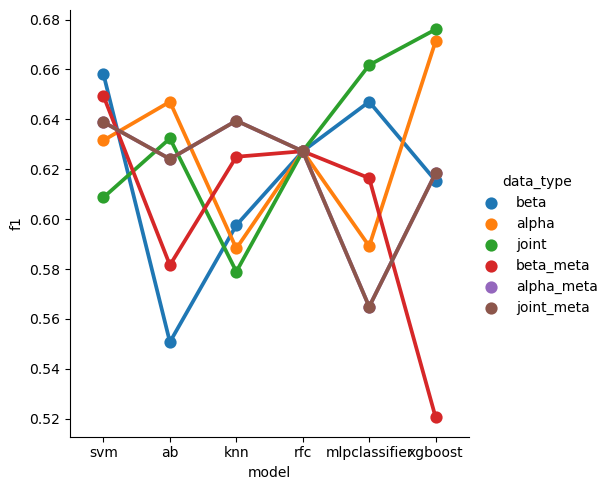

In [21]:
fig, ax = plt.subplots()
sns.catplot(data=comparison_df, x="model", y="f1", hue="data_type", kind="point", ax=ax)
plt.close(1)

<AxesSubplot:xlabel='model', ylabel='f1'>

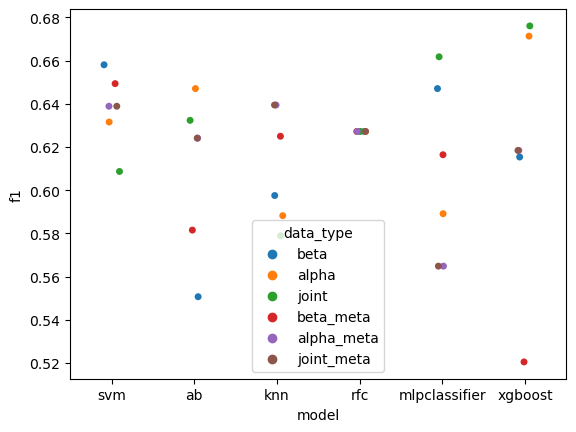

In [22]:
sns.stripplot(data=comparison_df, x="model", y="f1", hue="data_type",)

In [23]:
all_clfs['joint']

({'svm': Pipeline(steps=[('model',
                   SVC(C=1, kernel='linear', probability=True, random_state=42))]),
  'ab': Pipeline(steps=[('model',
                   AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                                      n_estimators=200, random_state=42))]),
  'knn': Pipeline(steps=[('model',
                   KNeighborsClassifier(leaf_size=1, n_neighbors=10,
                                        weights='distance'))]),
  'rfc': Pipeline(steps=[('model',
                   RandomForestClassifier(max_depth=1, min_samples_leaf=8,
                                          n_estimators=50, n_jobs=-1,
                                          random_state=42))]),
  'mlpclassifier': Pipeline(steps=[('model',
                   MLPClassifier(alpha=1e-05,
                                 hidden_layer_sizes=(150, 100, 50, 25, 10),
                                 max_iter=1000, random_state=42))]),
  'xgboost': Pipeline(steps=[('mo

# Making metrics dataframe

In [24]:
clf_name = []
clf_type = []
f1 = []
precision = []
recall = []
for key, clfs in all_clfs.items():
    clf_name.append(key)
    clf_type.append(clfs[2])
    best_clf = clfs[0]['svm']
    clf_predictions = best_clf.predict(X_test_data[key])
    f1.append(f1_score(y_test_data[key], clf_predictions))
    precision.append(precision_score(y_test_data[key], clf_predictions))
    recall.append(recall_score(y_test_data[key], clf_predictions))

In [25]:
plotting_df = pd.DataFrame({
    'classifier': clf_name, 
    'best_classifier_predictor': clf_type,
    'f1_score': f1,
    'precision_score': precision,
    'recall_score': recall
})

In [26]:
plotting_df

,classifier,best_classifier_predictor,f1_score,precision_score,recall_score
0,beta,svm,0.658065,0.500000,0.962264
1,alpha,xgboost,0.631579,0.484848,0.905660
2,joint,xgboost,0.608696,0.494118,0.792453
3,beta_meta,svm,0.649351,0.495050,0.943396
4,alpha_meta,knn,0.638889,0.505495,0.867925
5,joint_meta,knn,0.638889,0.505495,0.867925


In [27]:
plotting_df = plotting_df.applymap(lambda x: round(x, 2) if isinstance(x, float) else x)

# Preparing data for proba comparison

In [28]:
beta_predictions = all_clfs['beta'][0]['svm'].predict_proba(X_test_data['beta'])[::,1]
alpha_predictions = all_clfs['alpha'][0]['svm'].predict_proba(X_test_data['alpha'])[::,1]

proba_labels = y_test.apply(lambda x: 'healthy' if x == 0 else 'covid')
probability_df = pd.DataFrame({
    'beta_proba': beta_predictions,
    'alpha_proba': alpha_predictions,
    'covid': proba_labels
})

In [29]:
probability_df

,beta_proba,alpha_proba,covid
420,0.825440,0.966276,covid
421,0.653523,0.809848,covid
422,0.721762,0.552435,covid
423,0.709377,0.653637,covid
424,0.588253,0.907048,covid
...,...,...,...
531,0.647072,0.588919,healthy
532,0.808801,0.791630,healthy
533,0.712220,0.647328,healthy
534,0.636343,0.854361,healthy


# One folder out CV

In [30]:
data_joint

,CASSQTTKDEQYF,CASSQGQKDEQYF,CASSQFTGRKEKLFF,CASSLTSGGPTSDTQYF,CASTTPVTERYNEQFF,CASTTSRGAISTDTQYF,CASSQGTGGANEQYF,CASSLAGSTEAFF,CASSLAGSTEAFF.1,CASSLTSGGPVTDTQYF,...,CAFMKINQFYF,CAFLNAGGTSYGKLTF,CAVYNQGGKLIF,CAVRALYNFNKFYF,CAVESYNTDKLIF,CLVGENSGGFKTIF,CAMREGQGNAGNMLTF,covid,project,is_test_run
0,-0.062793,-0.11064,-0.04418,-0.032359,0.0,0.0,-0.110069,0.745466,0.745466,-0.07678,...,-0.161577,1.677709,0.046260,-0.371942,-1.305344,-0.222082,-0.400412,1,2020/10_FMBA_NovaSeq5,False
1,-0.062793,-0.11064,-0.04418,-0.032359,0.0,0.0,-0.110069,-1.080899,-1.080899,-0.07678,...,-0.161577,0.490398,-1.290622,-0.371942,1.036795,2.029925,-0.400412,1,2020/10_FMBA_NovaSeq5,False
2,-0.062793,-0.11064,-0.04418,-0.032359,0.0,0.0,-0.110069,-0.535745,-0.535745,-0.07678,...,-0.161577,0.256703,-1.412024,-0.371942,-0.076025,-0.222082,-0.400412,0,2020/10_FMBA_NovaSeq5,False
3,-0.062793,-0.11064,-0.04418,-0.032359,0.0,0.0,-0.110069,-1.080899,-1.080899,-0.07678,...,-0.161577,-1.375933,0.721560,-0.371942,0.148967,-0.222082,3.757343,1,2020/10_FMBA_NovaSeq5,False
4,-0.062793,-0.11064,-0.04418,-0.032359,0.0,0.0,-0.110069,2.058364,2.058364,-0.07678,...,-0.161577,-1.375933,0.018445,-0.371942,-0.168249,-0.222082,-0.400412,1,2020/10_FMBA_NovaSeq5,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,-0.062793,-0.11064,-0.04418,-0.032359,0.0,0.0,-0.110069,-1.080899,-1.080899,-0.07678,...,-0.161577,3.413831,-2.501948,-0.371942,4.104447,-0.222082,-0.400412,0,2020/10_FMBA_NovaSeq4,False
952,-0.062793,-0.11064,-0.04418,-0.032359,0.0,0.0,-0.110069,-0.180133,-0.180133,-0.07678,...,-0.161577,0.514424,-1.450302,-0.371942,2.964779,-0.222082,-0.400412,0,2020/10_FMBA_NovaSeq4,False
953,-0.062793,-0.11064,-0.04418,-0.032359,0.0,0.0,-0.110069,-1.080899,-1.080899,-0.07678,...,-0.161577,1.029539,-1.163733,-0.371942,0.505894,-0.222082,-0.400412,0,2020/10_FMBA_NovaSeq4,False
954,-0.062793,-0.11064,-0.04418,-0.032359,0.0,0.0,-0.110069,-1.080899,-1.080899,-0.07678,...,-0.161577,-1.375933,-0.078940,-0.371942,0.880974,-0.222082,-0.400412,0,2020/10_FMBA_NovaSeq4,False


In [31]:
desc_for_projects = pd.read_csv('data/desc_fmba_new_split.csv').drop(columns=['Unnamed: 0'])[['run', 'folder']]
desc_for_projects.head()

,run,folder
0,020000010808_S3_L001.clonotypes.TRB.txt,2020/10_FMBA_NovaSeq5
1,020000110808_S14_L001.clonotypes.TRB.txt,NovaSeq14
2,020000190808_S27_L001.clonotypes.TRB.txt,2020/10_FMBA_NovaSeq5
3,020000200808_S181_L002.clonotypes.TRB.txt,2020/10_FMBA_NovaSeq5
4,020000280808_S59_L001.clonotypes.TRB.txt,2020/10_FMBA_NovaSeq5


In [34]:
data_joint_proj = data_joint.copy()

In [35]:
data_joint_proj['project'] = desc_for_projects.folder.apply(lambda x: x.replace('_DNA', '').split('/')[-1].split('_')[-1])

In [36]:
data_joint_proj.project.unique()

array(['NovaSeq5', 'NovaSeq14', 'Novaseq8', 'NovaSeq6', 'Novaseq7',
       'NovaSeq24', 'NovaSeq34'], dtype=object)

In [37]:
data_joint_proj.head()

,CASSQTTKDEQYF,CASSQGQKDEQYF,CASSQFTGRKEKLFF,CASSLTSGGPTSDTQYF,CASTTPVTERYNEQFF,CASTTSRGAISTDTQYF,CASSQGTGGANEQYF,CASSLAGSTEAFF,CASSLAGSTEAFF.1,CASSLTSGGPVTDTQYF,...,CAFMKINQFYF,CAFLNAGGTSYGKLTF,CAVYNQGGKLIF,CAVRALYNFNKFYF,CAVESYNTDKLIF,CLVGENSGGFKTIF,CAMREGQGNAGNMLTF,covid,project,is_test_run
0,-0.062793,-0.11064,-0.04418,-0.032359,0.0,0.0,-0.110069,0.745466,0.745466,-0.07678,...,-0.161577,1.677709,0.046260,-0.371942,-1.305344,-0.222082,-0.400412,1,NovaSeq5,False
1,-0.062793,-0.11064,-0.04418,-0.032359,0.0,0.0,-0.110069,-1.080899,-1.080899,-0.07678,...,-0.161577,0.490398,-1.290622,-0.371942,1.036795,2.029925,-0.400412,1,NovaSeq14,False
2,-0.062793,-0.11064,-0.04418,-0.032359,0.0,0.0,-0.110069,-0.535745,-0.535745,-0.07678,...,-0.161577,0.256703,-1.412024,-0.371942,-0.076025,-0.222082,-0.400412,0,NovaSeq5,False
3,-0.062793,-0.11064,-0.04418,-0.032359,0.0,0.0,-0.110069,-1.080899,-1.080899,-0.07678,...,-0.161577,-1.375933,0.721560,-0.371942,0.148967,-0.222082,3.757343,1,NovaSeq5,False
4,-0.062793,-0.11064,-0.04418,-0.032359,0.0,0.0,-0.110069,2.058364,2.058364,-0.07678,...,-0.161577,-1.375933,0.018445,-0.371942,-0.168249,-0.222082,-0.400412,1,NovaSeq5,False


In [38]:
metrics_df = []
for metrics, metrics_name in zip([f1_score, precision_score, recall_score], ['f1', 'precision', 'recall']):
    metrics_df.append(cross_validation_between_batches(best_clfs_joint[0]['svm'], 
                                 data_joint_proj.drop(columns=['is_test_run']), 
                                 [x for x in data_joint_proj.project.unique()], 
                                 y_column='covid', 
                                 batch_column='project', 
                                 metrics=metrics, 
                                 metrics_name=metrics_name, 
                                 return_metrics_results=True,
                                 debug=True
                                 ))

NovaSeq5
Valid f1 for the model 0.78

NovaSeq14
Valid f1 for the model 0.82

Novaseq8
Valid f1 for the model 0.72

NovaSeq6
Valid f1 for the model 0.69

Novaseq7
Valid f1 for the model 0.81

NovaSeq24
Valid f1 for the model 0.86

NovaSeq34
Valid f1 for the model 0.81

NovaSeq5
Valid precision for the model 0.73

NovaSeq14
Valid precision for the model 0.82

Novaseq8
Valid precision for the model 0.62

NovaSeq6
Valid precision for the model 0.59

Novaseq7
Valid precision for the model 0.80

NovaSeq24
Valid precision for the model 0.92

NovaSeq34
Valid precision for the model 0.86

NovaSeq5
Valid recall for the model 0.83

NovaSeq14
Valid recall for the model 0.82

Novaseq8
Valid recall for the model 0.87

NovaSeq6
Valid recall for the model 0.83

Novaseq7
Valid recall for the model 0.82

NovaSeq24
Valid recall for the model 0.81

NovaSeq34
Valid recall for the model 0.77



In [39]:
def make_score_column(df):
    df['score'] = df[df.columns[1]]
    df['metrics'] = df.columns[1]
    df = df.drop(columns=[df.columns[1]])
    return df

metrics_df = pd.concat([make_score_column(metrics_df[i]) for i in range(3)])
metrics_df.folder = metrics_df.folder.apply(lambda x: x.replace('_DNA', '').split('/')[-1].split('_')[-1])

# Plotting

In [40]:
for key in all_clfs:
    all_clfs[key][0][all_clfs[key][2]].fit(X_train_data[key], y_train_data[key])

In [43]:
all_clfs.keys()

dict_keys(['beta', 'alpha', 'joint', 'beta_meta', 'alpha_meta', 'joint_meta'])

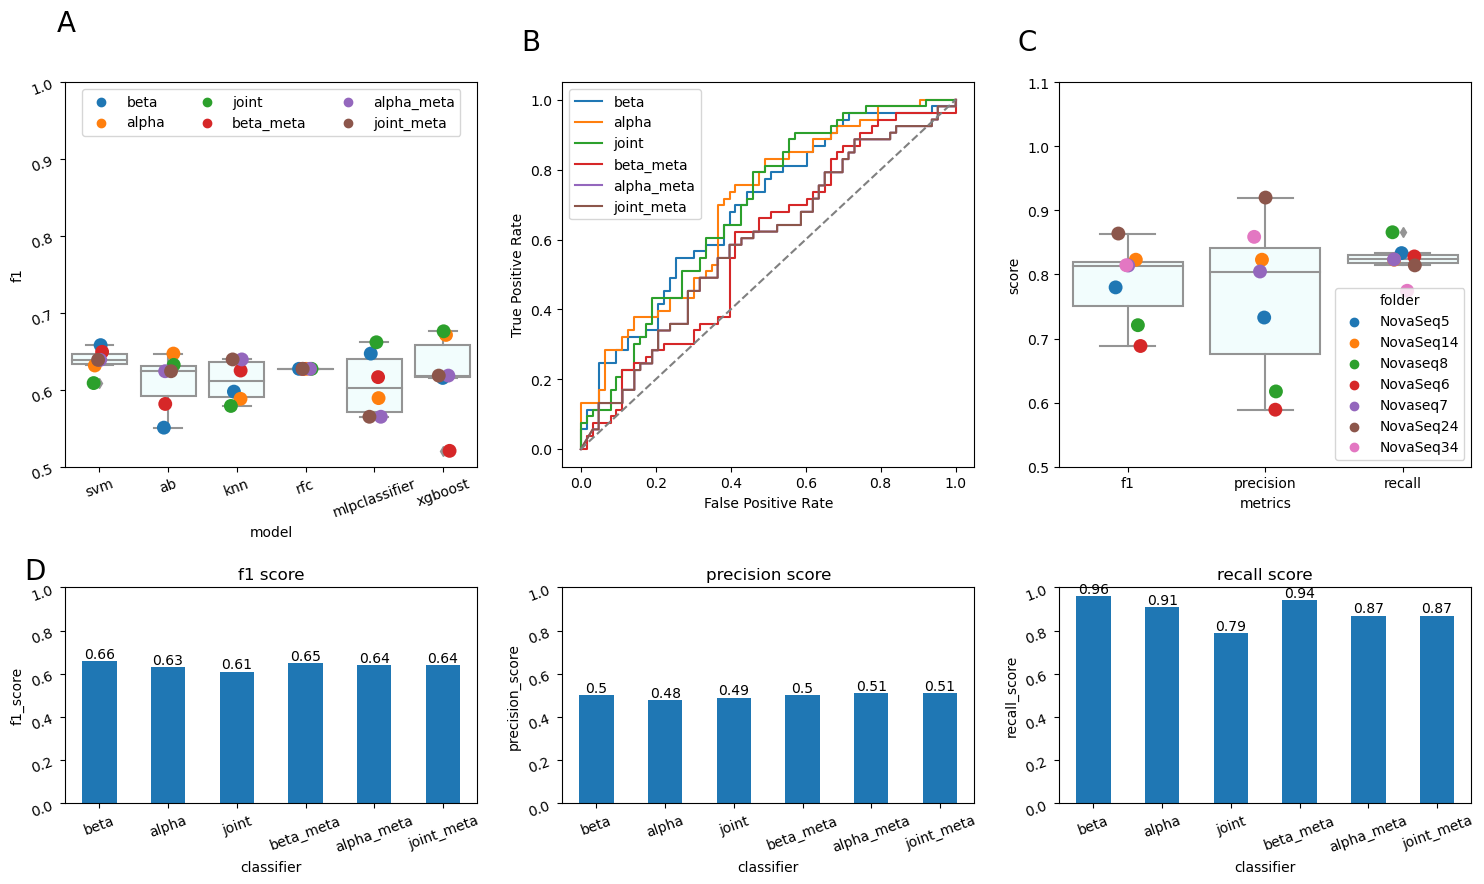

In [41]:
fig = plt.figure(figsize=(15, 20))
gs = GridSpec(nrows=12, 
              ncols=3)
font_size=20
delta_x=-0.1
delta_y=1.14


########################################################

for i, (letter, metrics) in enumerate(zip(['D', None, None], ['f1_score', 'precision_score', 'recall_score'])):
    
    ax = fig.add_subplot(gs[3:5, i])
    plotting_df[['classifier', metrics]].set_index('classifier').plot(kind='bar', ax=ax)
    ax.bar_label(ax.containers[0])
    ax.tick_params(labelrotation=20)
    ax.get_legend().remove()
    ax.set_ylabel(metrics)
    ax.set_title(f"{metrics.replace('_', ' ')}")
    ax.tick_params(labelrotation=20)
    ax.set_ylim(0, 1)
    if letter is not None:
        ax.text(delta_x, delta_y, letter,
             horizontalalignment='left',
             verticalalignment='top',
            transform=ax.transAxes,
                size=font_size)

########################################################
ax3 = fig.add_subplot(gs[:3, 1])

for key in all_clfs:
    fpr, tpr, _ = roc_curve(y_test_data[key], all_clfs[key][0][all_clfs[key][2]].predict_proba(X_test_data[key])[::,1])
    ax3.plot(fpr,tpr, label=key)

ax3.set_ylabel('True Positive Rate')
ax3.set_xlabel('False Positive Rate')
ax3.plot([0, 1], [0, 1], linestyle='dashed', color='grey')
ax3.legend()
# ax3.set_title('ROC-curve')
ax3.text(delta_x, delta_y, 'B',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax3.transAxes,
        size=font_size)

########################################################
ax7 = fig.add_subplot(gs[:3, 2])

sns.stripplot(data=metrics_df, x="metrics", y="score", hue="folder", s=10, ax=ax7)
sns.boxplot(data=metrics_df, x="metrics", y="score", color='azure', ax=ax7)
# ax7.set_title('Scores across batches for α+β metaclone classifier')
ax7.set_ylim(0.5, 1.1)
ax7.text(delta_x, delta_y, 'C',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax7.transAxes,
        size=font_size)

########################################################

ax9 = fig.add_subplot(gs[:3, 0])
sns.stripplot(data=comparison_df, x="model", y="f1", hue="data_type", ax=ax9, s=10)
sns.boxplot(data=comparison_df, x="model", y="f1", ax=ax9, color='azure')
ax9.text(delta_x+0.08, delta_y+0.05, 'A',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax9.transAxes,
        size=font_size)
# ax9.set_title('Comparison of f1-score across models')
ax9.tick_params(labelrotation=20)
ax9.set_ylim(0.5, 1)
ax9.legend(ncol=3,  loc='upper center')

########################################################

plt.tight_layout()
plt.savefig("figures/supp_fig3.svg")
plt.savefig("figures/supp_fig3.pdf")
plt.savefig("figures/supp_fig3.png")
plt.show()


Figure 4. Analysis of machine learning approaches applied to FMBA TCRβ and TCRα biomarkers. 

A, B, C. Distribution of target metrics (f1-score, precision, recall) for all the evaluated models.

D. ROC-curve plot for all the evaluated models.

E. The sctterplot describing the relation of the probabilities to label the sample as the COVID-19 positive for TRCα and TCRβ based classifiers.

F. The sctterplot describing the relation of the probabilities to label the sample as the COVID-19 positive for classifier based on both TRCα,TCRβ biomarkers and TRCα,TCRβ metaclone cluster features.

G. The waterfall plot representing the probability of each sample to be labeld as COVID-19 positiove (> 0) or healthy (< 0). Samples coming from healthy donors are colored with blue, COVID-19 samples are colored with orange.

H. Evaluation of target metrics (f1-score, precision, recall) for one batch out cross validation.

I. Feature importance plot for the XGBoost classifier based on TRCα and TCRβ based biomarkers and HLA presence features.